# SR Compare on the Mac device( apple silicon)

Models and Variants
1. mlx-whisper(tiny.en)
2. openai-whisper(tiny.en)
3. apple-speech-sfspeechrecognizer(en)
4. vosk(small.en)
5. whisper-cpp(tiny.en)

Dataset 
1. https://huggingface.co/datasets/google/fleurs
2. https://www.kaggle.com/datasets/vjcalling/speaker-recognition-audio-dataset

### Function

In [13]:
import os
import time
import librosa
import json
import numpy as np
import soundfile as sf
from Foundation import NSRunLoop, NSDate, NSURL
import Speech
import whisper
from pywhispercpp.model import Model as WhisperCppModel
import mlx_whisper
from vosk import Model as VoskModel, KaldiRecognizer

def transcribe_mlx_whisper(audio_path):

    """Transcribes audio using the mlx-whisper library."""
    start_time = time.time()
    result = mlx_whisper.transcribe(audio_path)
    end_time = time.time()
    text = result['text']
    duration = librosa.get_duration(path=audio_path)
    processing_time = end_time - start_time
    label="mlx-whisper" 
    return text, processing_time, duration, label

def transcribe_apple_speech(audio_path):
    """Transcribes audio using Apple's Speech framework."""
    url = NSURL.fileURLWithPath_(os.path.abspath(audio_path))
    request = Speech.SFSpeechURLRecognitionRequest.alloc().initWithURL_(url)
    recognizer = Speech.SFSpeechRecognizer.alloc().init()
    finished = False
    transcript = ""
    label="apple-speech"
    def handler(result, error):
        nonlocal finished, transcript
        if result:
            transcript = str(result.bestTranscription().formattedString())
            if result.isFinal():
                finished = True
        else:
            finished = True

    task = recognizer.recognitionTaskWithRequest_resultHandler_(request, handler)

    start_time = time.time()
    while not finished:
        NSRunLoop.currentRunLoop().runUntilDate_(
            NSDate.dateWithTimeIntervalSinceNow_(0.1)
        )
    end_time = time.time()
    duration = librosa.get_duration(path=audio_path)
    processing_time = end_time - start_time
    return transcript, processing_time, duration, label

def transcribe_whisper_cpp(audio_path, model_path='tiny.en', target_sr=16000):
    """Transcribes audio using the whisper.cpp library."""
    label="whisper-cpp"
    model = WhisperCppModel(model_path)
    audio, sr = librosa.load(audio_path, sr=target_sr)
    temp_path = f"temp_{os.path.basename(audio_path)}.wav"
    sf.write(temp_path, audio, target_sr)

    start_time = time.time()
    text = model.transcribe(temp_path)
    end_time = time.time()

    os.remove(temp_path)
    duration = librosa.get_duration(path=audio_path)
    processing_time = end_time - start_time
    return text, processing_time, duration, label

def transcribe_openai_whisper(audio_path, model_name="tiny.en"):
    """Transcribes audio using the openai-whisper library."""
    label="openai-whisper"
    model = whisper.load_model(model_name)
    start_time = time.time()
    result = model.transcribe(audio_path)
    end_time = time.time()
    text = result['text']
    duration = librosa.get_duration(path=audio_path)
    processing_time = end_time - start_time
    return text, processing_time, duration, label


def transcribe_vosk(audio_path, model_path="./models/vosk-model-small-en-us-0.15", sample_rate=16000, chunk_samples=4000):
    """Transcribes audio using the vosk library."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Vosk model not found at {model_path}")
    
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")
    
    model = VoskModel(model_path)
    waveform, sr = librosa.load(audio_path, sr=sample_rate, mono=True)
    
    rec = KaldiRecognizer(model, sample_rate)
    rec.SetWords(True)
    label = "vosk"
    
    start_time = time.time()
    
    for i in range(0, len(waveform), chunk_samples):
        chunk = waveform[i : i + chunk_samples]
        pcm16 = (chunk * 32767).astype(np.int16).tobytes()
        rec.AcceptWaveform(pcm16)
    
    result = json.loads(rec.FinalResult())
    text = result.get("text", "")
    
    end_time = time.time()
    processing_time = end_time - start_time
    duration = librosa.get_duration(y=waveform, sr=sr)
    
    return text, processing_time, duration, label



/opt/miniconda3/envs/mlx-whisper/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## RTF real-time factor 

In [12]:
import csv
import random
import os

def process_audio_files_time_metrixc(samples_folder='dataset/kaggle', output_csv='asr_results_measure_eer_results.csv', num_samples=60):
    """Processes randomly selected audio files with different STT models and saves results to CSV."""
    # Get all audio files from main folder and subfolders
    audio_files = []
    for root, _, files in os.walk(samples_folder):
        for file in files:
            if file.endswith(('.wav', '.flac', '.mp3', '.m4a', '.aiff', '.aif')):
                audio_files.append(os.path.join(root, file))
    
    # Randomly select 60 audio files
    selected_files = random.sample(audio_files, min(num_samples, len(audio_files)))
    print(f"Randomly selected {len(selected_files)} audio files to process")
    results = []

    # Initialize models (optional, but can be done once for efficiency if needed)
    apple_speech_available = hasattr(Speech, 'SFSpeechRecognizer')
    whisper_cpp_model = WhisperCppModel('tiny.en') if 'tiny.en' else None
    openai_whisper_model = whisper.load_model("tiny") if 'tiny' else None
    vosk_model = VoskModel("./models/vosk-model-small-en-us-0.15") if os.path.exists("./models/vosk-model-small-en-us-0.15") else None

    # Create CSV file and write header
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['filename', 'duration', 'model', 'transcription', 'processing_time', 'processing_time_per_duration', 'status']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for audio_path in sorted(selected_files):
            print(f"\nProcessing file: {audio_path}")
            try:
                duration = librosa.get_duration(path=audio_path)
                duration_ms = duration * 1000  # Convert to milliseconds
            except Exception as e:
                print(f"Error getting duration: {e}")
                continue

            # Process each model and write results to CSV
            models_to_process = {
                'mlx_whisper': transcribe_mlx_whisper,
                'apple_speech': transcribe_apple_speech if apple_speech_available else None,
                'whisper_cpp': transcribe_whisper_cpp,
                'openai_whisper': transcribe_openai_whisper,
                'vosk': transcribe_vosk if vosk_model else None
            }

            for model_name, transcribe_func in models_to_process.items():
                print(f"  Running {model_name}...")
                if transcribe_func is None:
                    writer.writerow({
                        'filename': os.path.basename(audio_path),
                        'duration': duration_ms,
                        'model': model_name,
                        'transcription': '',
                        'processing_time': '',
                        'processing_time_per_duration': '',
                        'status': 'Not available'
                    })
                    continue

                try:
                    text, processing_time, _, label = transcribe_func(audio_path)
                    processing_time_ms = processing_time * 1000  # Convert to milliseconds
                    writer.writerow({
                        'filename': os.path.basename(audio_path),
                        'duration': duration_ms,
                        'model': model_name,
                        'transcription': text,
                        'processing_time': processing_time_ms,
                        'processing_time_per_duration': processing_time_ms / duration_ms if duration_ms > 0 else None,
                        'status': 'Success'
                    })
                except Exception as e:
                    writer.writerow({
                        'filename': os.path.basename(audio_path),
                        'duration': duration_ms,
                        'model': model_name,
                        'transcription': '',
                        'processing_time': '',
                        'processing_time_per_duration': '',
                        'status': f'Error: {str(e)}'
                    })

    print(f"Results have been saved to {output_csv}")

In [ ]:
process_audio_files_time_metrixc(samples_folder='dataset/google_fleurs/train', output_csv='asr_results_measure_eer_results.csv', num_samples=60)

### plot the results



In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

def plot_real_time_factor_plots(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Filter out rows where transcription is empty
    df = df[df['transcription'].notna() & (df['transcription'] != '')]
    
    # Convert processing_time to numeric values, handling both string and numeric types
    df['processing_time'] = df['processing_time'].apply(lambda x: float(str(x).replace(' ms', '')) if pd.notna(x) else None)
    
    # Convert duration to numeric values, handling both string and numeric types
    df['duration'] = df['duration'].apply(lambda x: float(str(x).replace(' ms', '')) if pd.notna(x) else None)
    
    # Calculate real-time factor (RTF) - processing time / audio duration
    df['real_time_factor'] = df['processing_time'] / df['duration']
    
    # Calculate median RTF for each model
    median_rtf = df.groupby('model')['real_time_factor'].median().reset_index()
    median_rtf.columns = ['Model', 'Median RTF']
    median_rtf['Median RTF'] = median_rtf['Median RTF'].round(4)
    
    # Print the median RTF table
    print("\nMedian Real-Time Factor (RTF) by Model:")
    print(tabulate(median_rtf, headers='keys', tablefmt='pretty', showindex=False))
    print("\n")
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Box plot
    ax1.boxplot([df[df['model'] == model]['real_time_factor'] for model in df['model'].unique()],
                labels=df['model'].unique())
    ax1.set_title('Real-Time Factor (RTF) Distribution by ASR Model - Box Plot')
    ax1.set_xlabel('ASR Model')
    ax1.set_ylabel('Real-Time Factor (RTF)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_ylim(0, 0.2)
    ax1.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Real-time threshold')
    ax1.legend()
    
    # Violin plot
    ax2.violinplot([df[df['model'] == model]['real_time_factor'] for model in df['model'].unique()])
    ax2.set_title('Real-Time Factor (RTF) Distribution by ASR Model - Violin Plot')
    ax2.set_xlabel('ASR Model')
    ax2.set_ylabel('Real-Time Factor (RTF)')
    ax2.set_xticks(range(1, len(df['model'].unique()) + 1))
    ax2.set_xticklabels(df['model'].unique(), rotation=45)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_ylim(0, 0.2)
    ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Real-time threshold')
    ax2.legend()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()



Median Real-Time Factor (RTF) by Model:
+----------------+------------+
|     Model      | Median RTF |
+----------------+------------+
|  apple_speech  |   0.0671   |
|  mlx_whisper   |   0.0144   |
| openai_whisper |   0.0327   |
|      vosk      |   0.0557   |
|  whisper_cpp   |   0.0115   |
+----------------+------------+




/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_86991/1071554734.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([df[df['model'] == model]['real_time_factor'] for model in df['model'].unique()],


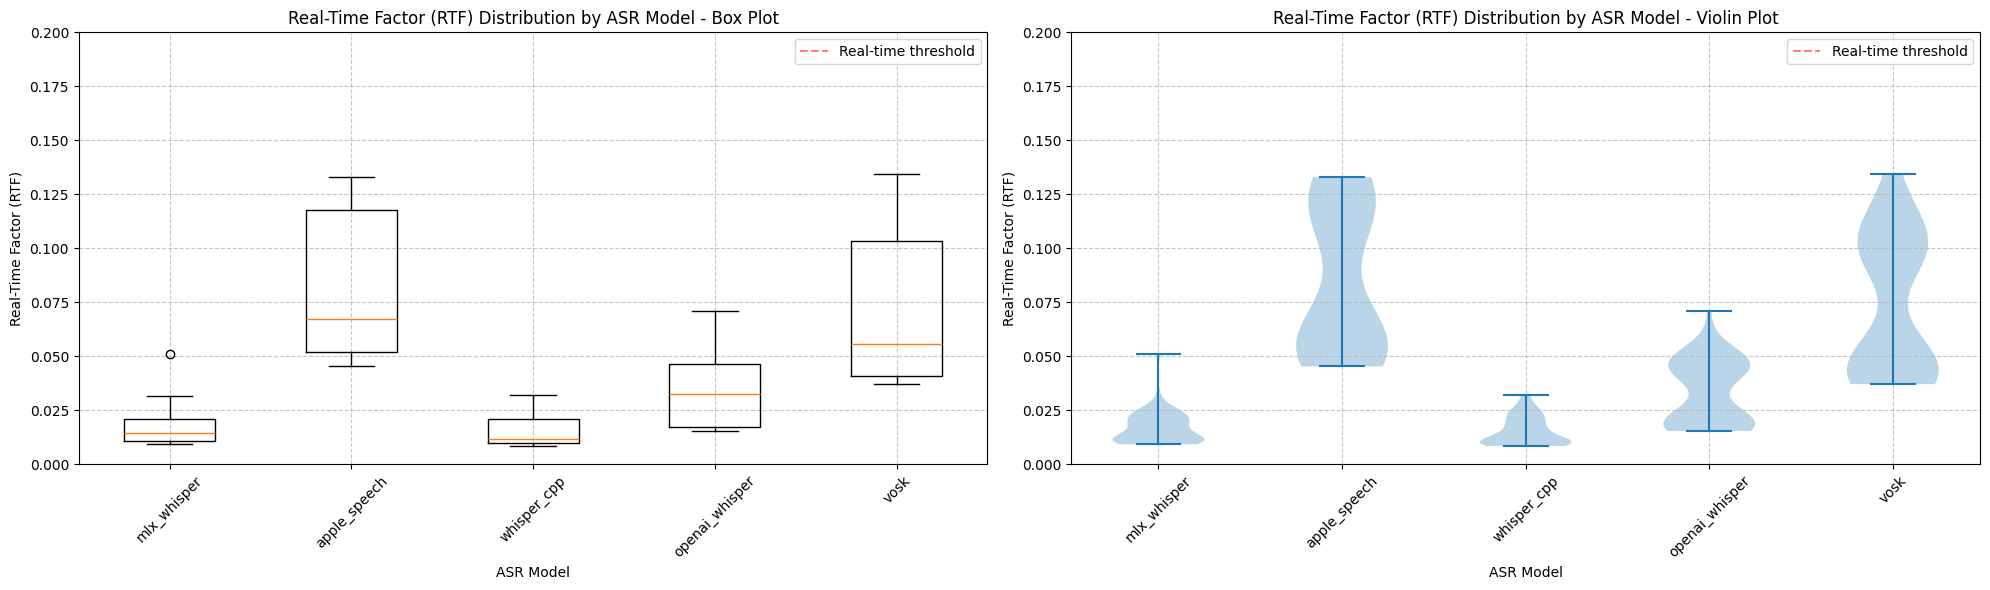


Median Real-Time Factor (RTF) by Model:
+----------------+------------+
|     Model      | Median RTF |
+----------------+------------+
|  apple_speech  |   0.0527   |
|  mlx_whisper   |   0.018    |
| openai_whisper |   0.0243   |
|      vosk      |   0.0768   |
|  whisper_cpp   |   0.0126   |
+----------------+------------+




/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_86991/1071554734.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([df[df['model'] == model]['real_time_factor'] for model in df['model'].unique()],


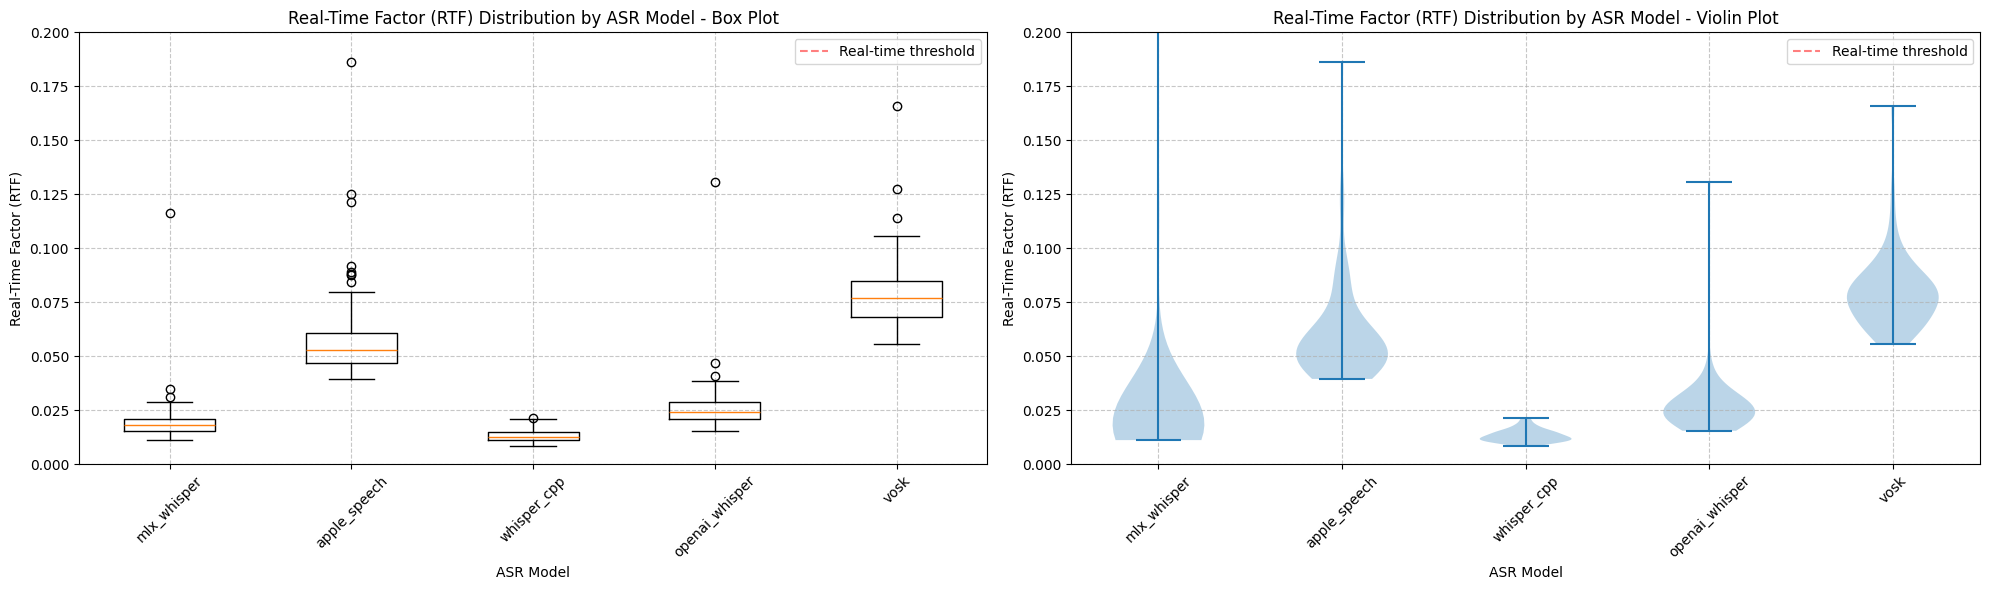

In [63]:
# Call the function with the CSV file

# Read the CSV file
result_csv="asr_results_time_metrix.csv"
# csv's attributes: filename,duration,model,transcription,processing_time,processing_time_per_duration,status

eer_csv="asr_results_measure_eer_results.csv"
plot_real_time_factor_plots(result_csv)
plot_real_time_factor_plots(eer_csv)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_rtf_stability(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Convert processing_time and duration to numeric values, handling both string and numeric formats
    df['processing_time'] = df['processing_time'].apply(lambda x: float(str(x).replace(' ms', '')) if isinstance(x, str) else float(x))
    df['duration'] = df['duration'].apply(lambda x: float(str(x).replace(' ms', '')) if isinstance(x, str) else float(x))
    
    # Calculate real-time factor (RTF)
    df['rtf'] = df['processing_time'] / df['duration']
    
    # Create a figure
    plt.figure(figsize=(15, 8))
    
    # Plot RTF for each model with different colors
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        plt.plot(range(len(model_data)), model_data['rtf'], 
                label=model, marker='o', markersize=4, alpha=0.7)
    
    plt.title('Real-Time Factor (RTF) Stability Across Files')
    plt.xlabel('File Index')
    plt.ylabel('Real-Time Factor (RTF)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Add a horizontal line at RTF = 1.0 to indicate real-time threshold
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Real-time threshold')
    
    # Set y-axis limits to 0-0.2
    plt.ylim(0, 0.2)
    
    plt.tight_layout()
    plt.show()


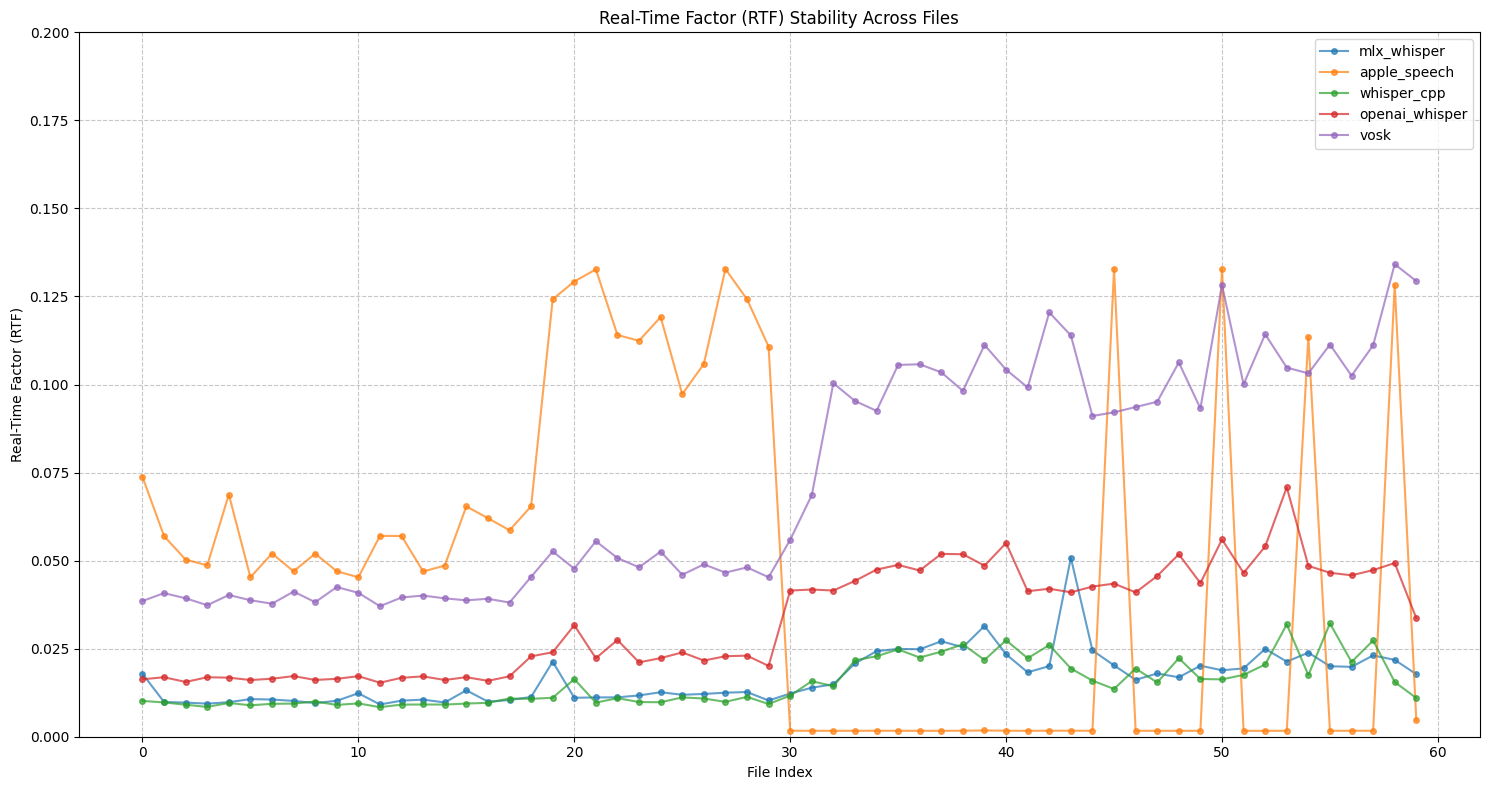

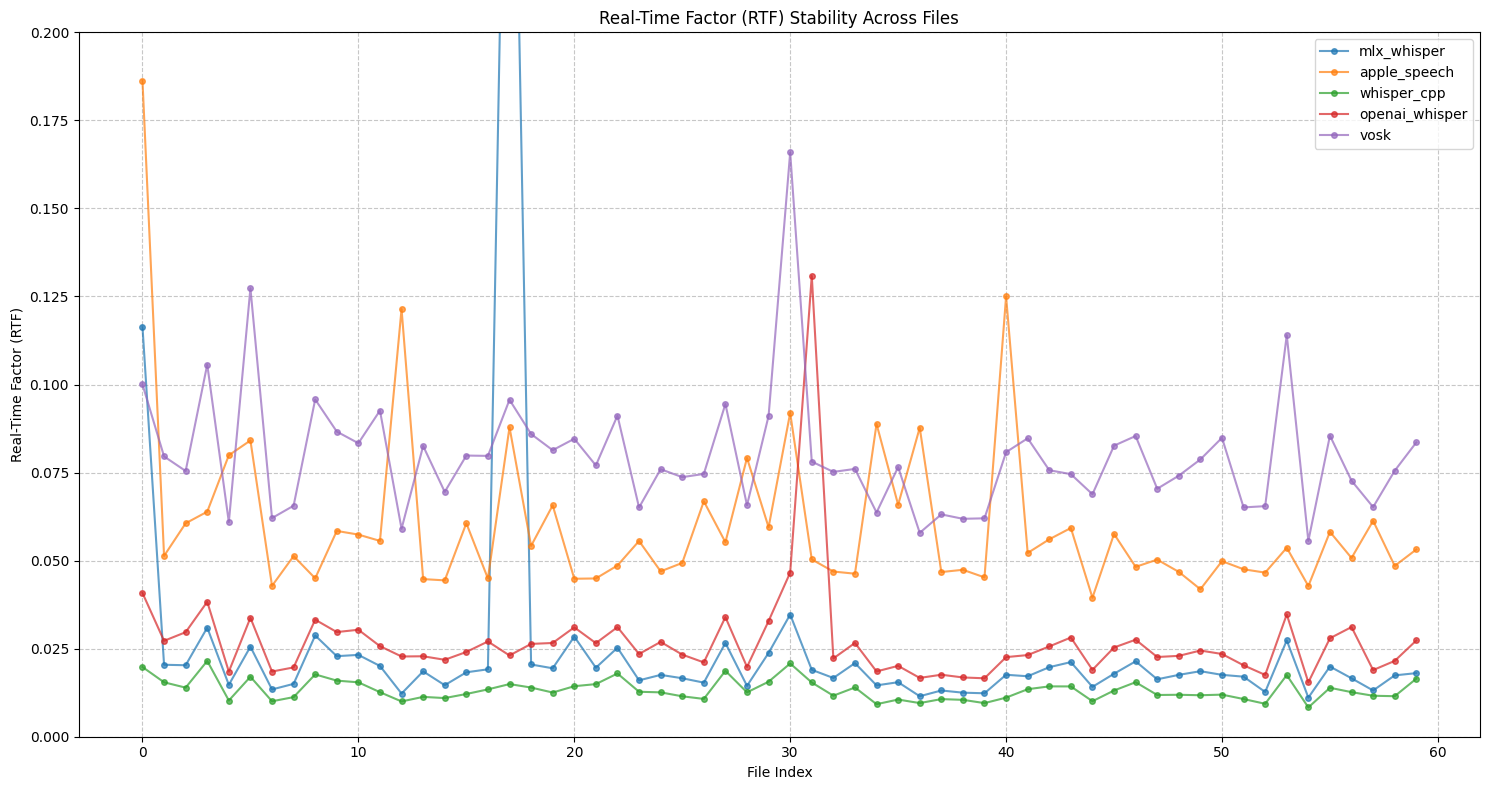

In [21]:

# Call the function
plot_rtf_stability(result_csv)
plot_rtf_stability(eer_csv)

## WER 

In [49]:
from jiwer import wer,wil
reference = " one two three four five six seven eight nine ten"
hypothesis = " one 2 three four five six seven eight nine ten"

error = wer(reference, hypothesis)
lost=wil(reference, hypothesis)
print(error)
print(lost)

0.1
0.18999999999999995


In [53]:

csv_file="asr_results_measure_eer_results.csv"
tsv_file="dataset/google_fleurs/train.tsv"


import pandas as pd
from jiwer import wer as calculate_wer ,wil as calculate_wil
import re
import string

def calculate_asr_metrics(csv_filepath, tsv_filepath):
    """
    Calculates Word Error Rate (WER) and Word Information Lost (WIL)
    by comparing transcriptions from a CSV file against ground truth from a TSV file.

    Args:
        csv_filepath (str): Path to the CSV file containing ASR results.
        tsv_filepath (str): Path to the TSV file containing ground truth text.

    Returns:
        pandas.DataFrame: Updated DataFrame from the CSV file with 'WER' and 'WIL' columns.
    """
    try:
        df_transcriptions = pd.read_csv(csv_filepath)
    except FileNotFoundError:
        return "Error: CSV file not found."

    try:
        df_ground_truth = pd.read_csv(tsv_filepath, sep='\t', header=None, names=['id', 'filename', 'raw_text', 'ground_truth_text', 'phonetic_transcription', 'duration_ms', 'gender'])
    except FileNotFoundError:
        return "Error: TSV file not found."

    ground_truth_dict = df_ground_truth.set_index('filename')['ground_truth_text'].to_dict()
    df_transcriptions['WER'] = None
    df_transcriptions['WIL'] = None

    def normalize_text(text):
        if isinstance(text, str):
            text = text.lower()
            text = text.translate(str.maketrans('', '', string.punctuation))
            text = re.sub(r'\s+', ' ', text).strip()
            text = re.sub(r'\b(one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand)\b', lambda match: str({'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10, 'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14, 'fifteen': 15, 'sixteen': 16, 'seventeen': 17, 'eighteen': 18, 'nineteen': 19, 'twenty': 20, 'thirty': 30, 'forty': 40, 'fifty': 50, 'sixty': 60, 'seventy': 70, 'eighty': 80, 'ninety': 90, 'hundred': 100, 'thousand': 1000}.get(match.group(0), match.group(0))), text)
            text = re.sub(r'\b(\d+)\b', lambda match: match.group(0), text) # Keep digits for now
            return text
        return ""

    for index, row in df_transcriptions.iterrows():
        filename = row['filename']
        transcription = str(row['transcription'])
        ground_truth = ground_truth_dict.get(filename)

        if ground_truth:
            # Handle whisper_cpp timestamp format
            if row['model'] == 'whisper_cpp':
                transcription = ' '.join(re.findall(r'text=([^\]]+)', transcription))

            normalized_transcription = normalize_text(transcription)
            normalized_ground_truth = normalize_text(ground_truth)

            print("filename:",filename, "model:",row['model'])
            print("normalized_ground_truth:",normalized_ground_truth)
            print("normalized_transcription:",normalized_transcription)
            if normalized_ground_truth:
                wer_result = calculate_wer(normalized_ground_truth, normalized_transcription)
                df_transcriptions.loc[index, 'WER'] = wer_result
                df_transcriptions.loc[index, 'WIL'] = wer_result # For single reference, WIL is the same as WER
            else:
                df_transcriptions.loc[index, 'WER'] = None
                df_transcriptions.loc[index, 'WIL'] = None
        else:
            df_transcriptions.loc[index, 'WER'] = None
            df_transcriptions.loc[index, 'WIL'] = None

    return df_transcriptions

# Example of how you would call this function in your Jupyter Notebook:
# csv_file = 'your_transcription_results.csv'
# tsv_file = 'your_ground_truth.tsv'
updated_df = calculate_asr_metrics(csv_file, tsv_file)
print(updated_df)
print(updated_df.columns)
print(updated_df.head())


filename: 10699068999125924254.wav model: mlx_whisper
normalized_ground_truth: moreover failure to do so has serious consequences growth depression malnutrition and ultimately death
normalized_transcription: moreover failure to do so has serious consequences growth depression malnutrition and ultimately death
filename: 10699068999125924254.wav model: apple_speech
normalized_ground_truth: moreover failure to do so has serious consequences growth depression malnutrition and ultimately death
normalized_transcription: moreover failed to do so has serious consequences growth depression malnutrition and ultimately death
filename: 10699068999125924254.wav model: whisper_cpp
normalized_ground_truth: moreover failure to do so has serious consequences growth depression malnutrition and ultimately death
normalized_transcription: moreover failure to do so has serious consequences growth depression malnutrition and ultimately death
filename: 10699068999125924254.wav model: openai_whisper
normalized


Median WER by Model:
model
mlx_whisper       0.061111
openai_whisper      0.0625
apple_speech      0.074176
vosk              0.148352
whisper_cpp        0.16388


/var/folders/4m/4mq00kz14230_q153p1_qdn80000gn/T/ipykernel_86991/2866575710.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(wer_data_boxplot,


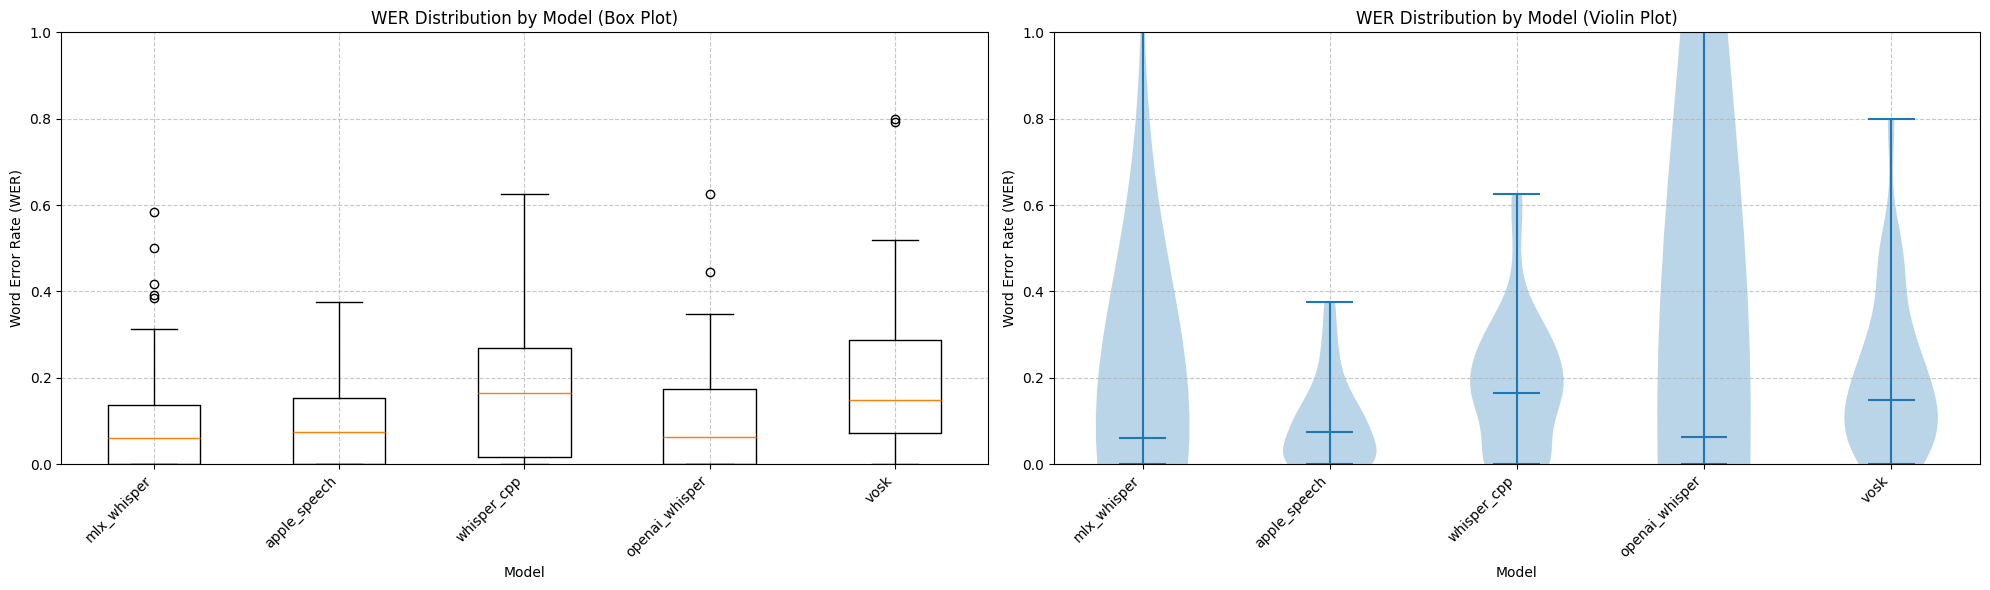

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_wer_comparison(df):
    """
    Plot WER comparison for different models using both box and violin plots.

    Args:
        df: DataFrame containing the ASR results with 'model' and 'WER' columns
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Prepare data for plotting, handling potential None values
    model_names = df['model'].unique()
    wer_data_boxplot = []
    wer_data_violin = []
    valid_violin_models = []
    
    # Calculate and display median WER for each model
    median_wer = df.groupby('model')['WER'].median().sort_values()
    print("\nMedian WER by Model:")
    print(median_wer.to_string())

    for model in model_names:
        model_data = df[df['model'] == model]['WER'].dropna()
        wer_data_boxplot.append(model_data.tolist())
        violin_data = model_data.tolist()
        if len(violin_data) >= 2:  # Violin plots require at least 2 data points
            wer_data_violin.append(violin_data)
            valid_violin_models.append(model)
        else:
            print(f"Warning: Model '{model}' has less than 2 data points and will not be displayed in the violin plot.")

    # Box plot
    ax1.boxplot(wer_data_boxplot,
                labels=model_names,
                showfliers=True)
    ax1.set_title('WER Distribution by Model (Box Plot)')
    ax1.set_ylabel('Word Error Rate (WER)')
    ax1.set_xlabel('Model')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_ylim(0, 1)  # Set y-axis range from 0 to 1
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.set_xticks(np.arange(1, len(model_names) + 1))

    # Violin plot
    if wer_data_violin:
        ax2.violinplot(wer_data_violin, showextrema=True, showmedians=True)
        ax2.set_title('WER Distribution by Model (Violin Plot)')
        ax2.set_ylabel('Word Error Rate (WER)')
        ax2.set_xlabel('Model')
        ax2.set_xticks(range(1, len(valid_violin_models) + 1))
        ax2.set_xticklabels(valid_violin_models, rotation=45, ha='right')
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.set_ylim(0, 1)  # Set y-axis range from 0 to 1
    else:
        ax2.text(0.5, 0.5, 'No models with sufficient data for violin plot', ha='center', va='center')

    plt.tight_layout()
    plt.show()

# Call the function with the updated dataframe
plot_wer_comparison(updated_df)


# combine the wer and rtf 

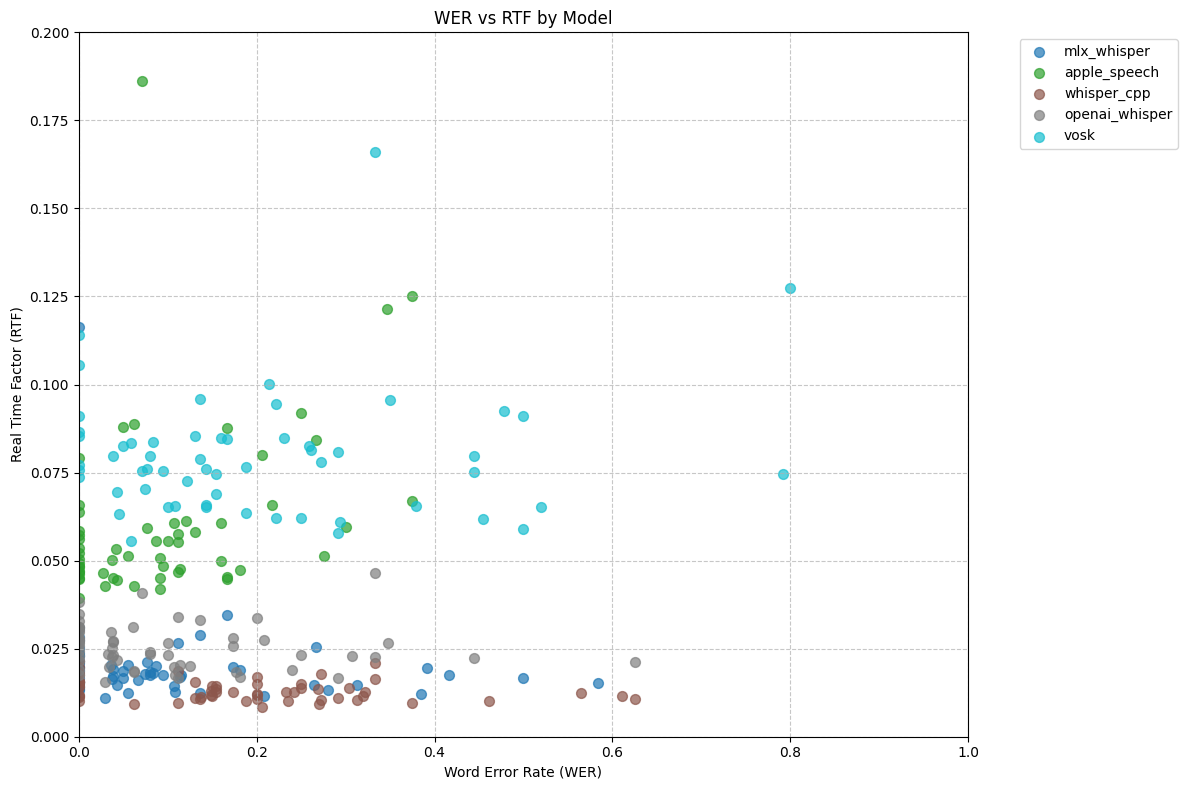

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_wer_rtf_comparison(df):
    """
    Plot scatter plot comparing WER and RTF for different models.
    Each model is represented by a different color.

    Args:
        df: DataFrame containing the ASR results with 'model', 'WER', and 'processing_time_per_duration' columns
    """
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Get unique models and assign colors
    models = df['model'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    
    # Plot scatter points for each model
    for model, color in zip(models, colors):
        model_data = df[df['model'] == model]
        plt.scatter(model_data['WER'], 
                   model_data['processing_time_per_duration'],
                   label=model,
                   color=color,
                   alpha=0.7,
                   s=50)  # Reduced point size from 100 to 50
    
    # Customize plot
    plt.title('WER vs RTF by Model')
    plt.xlabel('Word Error Rate (WER)')
    plt.ylabel('Real Time Factor (RTF)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set axis limits
    plt.xlim(0, 1)  # WER range from 0 to 1
    plt.ylim(0, 0.2)  # RTF range from 0 to 0.2
    
    plt.tight_layout()
    plt.show()

# Call the function with the updated dataframe
plot_wer_rtf_comparison(updated_df)


## Diagram



Model,Median RTF (dataset 1),Median RTF (dataset 2)
apple_speech,0.0671,0.0527
mlx_whisper(tiny),0.0144,0.0180
whisper_cpp(tiny.en),0.0115,0.0126
openai_whisper(tiny.en),0.0327,0.0243
vosk(small-en-us),0.0557,0.0768

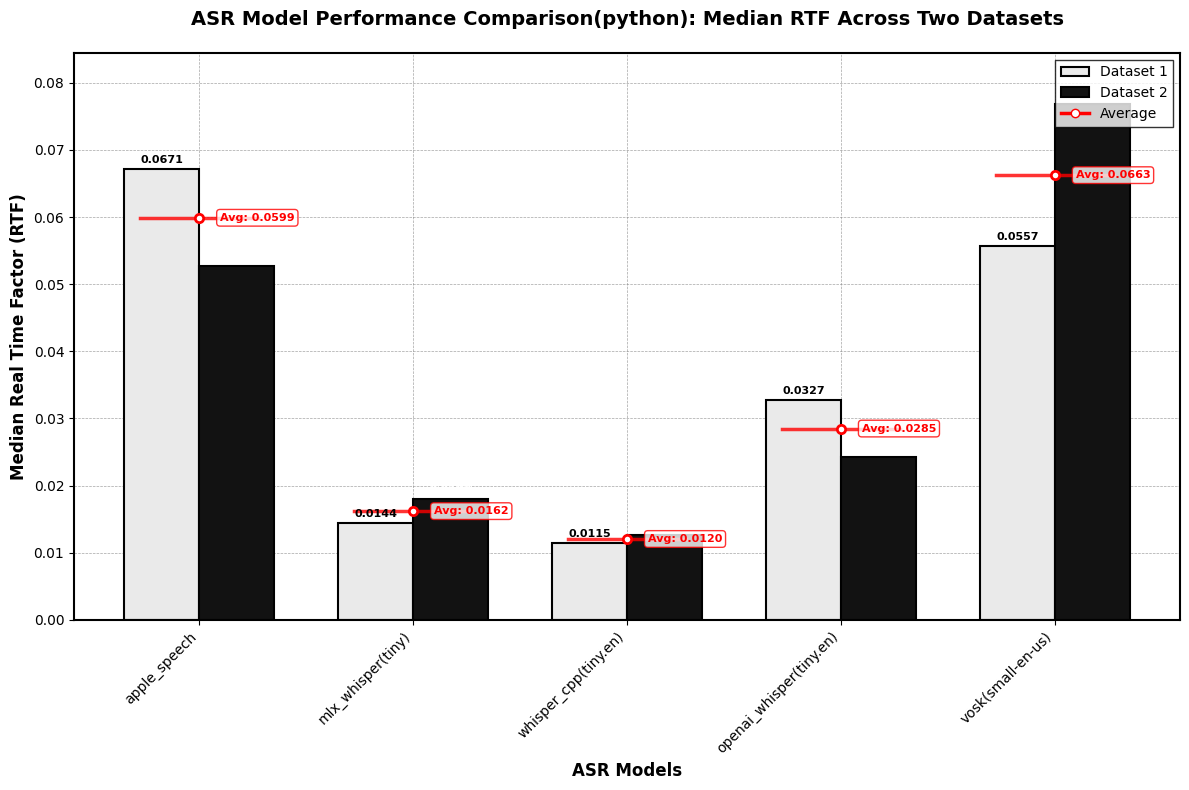


RTF Performance Summary:
apple_speech         | Dataset 1: 0.0671 | Dataset 2: 0.0527 | Average: 0.0599
mlx_whisper(tiny)    | Dataset 1: 0.0144 | Dataset 2: 0.0180 | Average: 0.0162
whisper_cpp(tiny.en) | Dataset 1: 0.0115 | Dataset 2: 0.0126 | Average: 0.0120
openai_whisper(tiny.en) | Dataset 1: 0.0327 | Dataset 2: 0.0243 | Average: 0.0285
vosk(small-en-us)    | Dataset 1: 0.0557 | Dataset 2: 0.0768 | Average: 0.0663

Best performing model (lowest average RTF): whisper_cpp(tiny.en)
Worst performing model (highest average RTF): vosk(small-en-us)


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# RTF data from the measurements
data = {
    'Model': ['apple_speech', 'mlx_whisper(tiny)', 'whisper_cpp(tiny.en)', 
              'openai_whisper(tiny.en)', 'vosk(small-en-us)'],
    'Dataset 1': [0.0671, 0.0144, 0.0115, 0.0327, 0.0557],
    'Dataset 2': [0.0527, 0.0180, 0.0126, 0.0243, 0.0768]
}

df_rtf = pd.DataFrame(data)

# Calculate averages
df_rtf['Average'] = (df_rtf['Dataset 1'] + df_rtf['Dataset 2']) / 2

# Create figure with black and white style
plt.style.use('default')  # Reset to default style
fig, ax = plt.subplots(figsize=(12, 8))

# Set up the bar positions
x = np.arange(len(df_rtf['Model']))
width = 0.35

# Create bars with custom black and white styling
bars1 = ax.bar(x - width/2, df_rtf['Dataset 1'], width, 
               label='Dataset 1', color='#eaeaea', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, df_rtf['Dataset 2'], width, 
               label='Dataset 2', color='#121212', edgecolor='black', linewidth=1.5)

# Add average lines and markers for each model
for i, (idx, row) in enumerate(df_rtf.iterrows()):
    avg_value = row['Average']
    # Draw horizontal line across both bars showing average
    line_start = x[i] - width/2 - 0.1
    line_end = x[i] + width/2 + 0.1
    ax.plot([line_start, line_end], [avg_value, avg_value], 
            color='red', linewidth=2.5, linestyle='-', alpha=0.8)
    
    # Add circular marker at the center
    ax.plot(x[i], avg_value, marker='o', color='red', markersize=6, 
            markerfacecolor='white', markeredgecolor='red', markeredgewidth=2)
    
    # Add average value text
    ax.annotate(f'Avg: {avg_value:.4f}',
                xy=(x[i], avg_value),
                xytext=(15, 0),  # 15 points horizontal offset
                textcoords="offset points",
                ha='left', va='center',
                fontsize=8, fontweight='bold', color='red',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='red', alpha=0.8))

# Customize the plot with black and white theme
ax.set_xlabel('ASR Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Real Time Factor (RTF)', fontsize=12, fontweight='bold')
ax.set_title('ASR Model Performance Comparison(python): Median RTF Across Two Datasets', 
             fontsize=14, fontweight='bold', pad=20)

# Set x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(df_rtf['Model'], rotation=45, ha='right', fontsize=10)

# Add legend with black and white styling (including average line)
from matplotlib.lines import Line2D
custom_lines = [bars1[0], bars2[0], 
                Line2D([0], [0], color='red', linewidth=2.5, marker='o', 
                       markerfacecolor='white', markeredgecolor='red')]
legend = ax.legend(custom_lines, ['Dataset 1', 'Dataset 2', 'Average'], 
                  loc='upper right', frameon=True, fancybox=False, shadow=False)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')

# Add grid with subtle black lines
ax.grid(True, linestyle='--', alpha=0.7, color='gray', linewidth=0.5)
ax.set_axisbelow(True)

# Set y-axis to start from 0 for better comparison
ax.set_ylim(0, max(max(df_rtf['Dataset 1']), max(df_rtf['Dataset 2'])) * 1.1)

# Add value labels on top of bars
def add_value_labels(bars, text_color='black'):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, fontweight='bold', color=text_color)

add_value_labels(bars1, 'black')  # Black text on light bars
add_value_labels(bars2, 'white')  # White text on dark bars

# Set black border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Print summary statistics
print("\nRTF Performance Summary:")
print("=" * 50)
for i, model in enumerate(df_rtf['Model']):
    d1_rtf = df_rtf['Dataset 1'][i]
    d2_rtf = df_rtf['Dataset 2'][i]
    avg_rtf = df_rtf['Average'][i]
    print(f"{model:<20} | Dataset 1: {d1_rtf:.4f} | Dataset 2: {d2_rtf:.4f} | Average: {avg_rtf:.4f}")

print(f"\nBest performing model (lowest average RTF): {df_rtf['Model'][df_rtf['Average'].idxmin()]}")
print(f"Worst performing model (highest average RTF): {df_rtf['Model'][df_rtf['Average'].idxmax()]}")


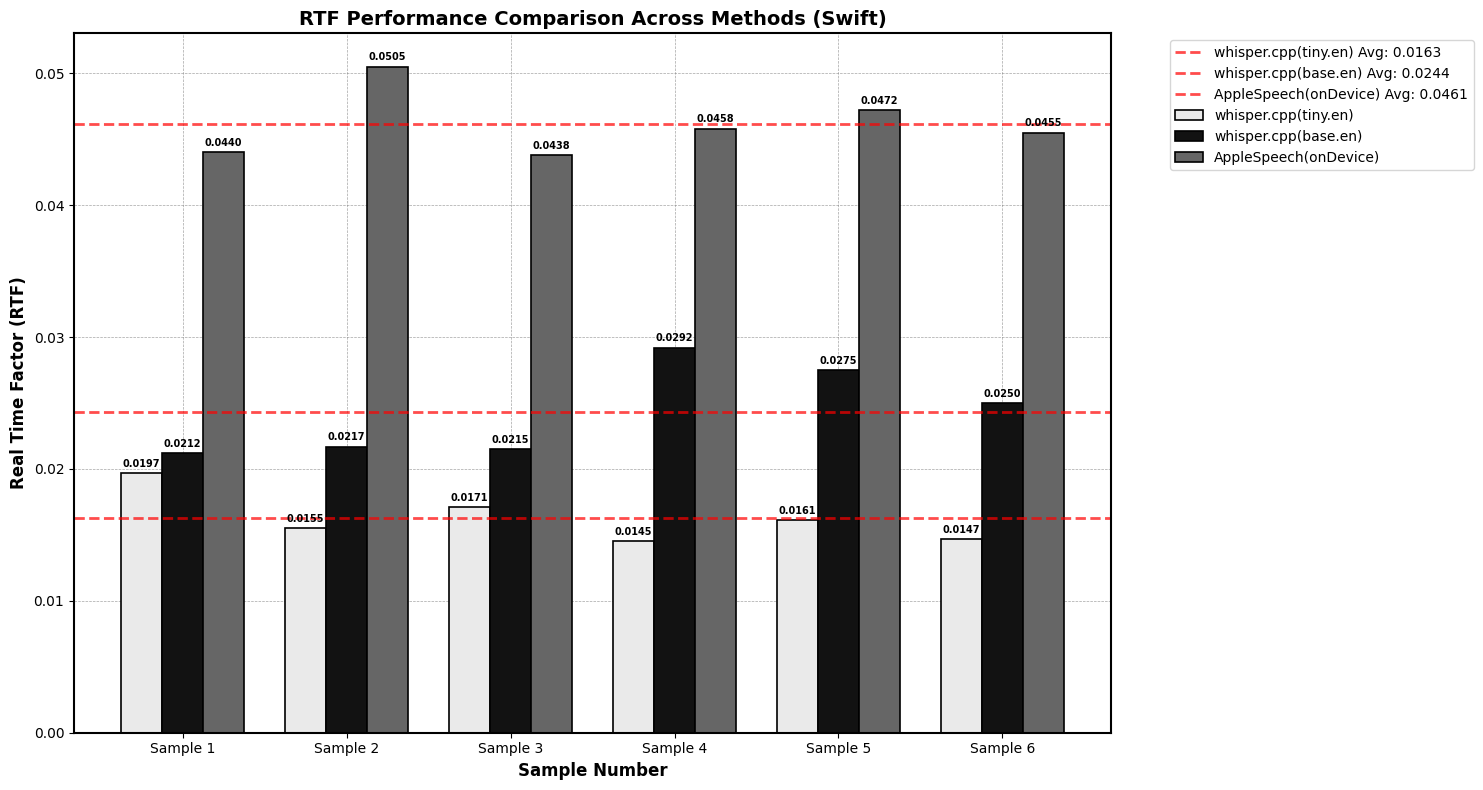


RTF Performance Summary:
whisper.cpp(tiny.en): Average RTF = 0.0163
whisper.cpp(base.en): Average RTF = 0.0244
AppleSpeech(onDevice): Average RTF = 0.0461


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# RTF data for the 3 approaches with 6 samples each
rtf_data = {
    'whisper.cpp(tiny.en)': [0.0197, 0.0155, 0.0171, 0.0145, 0.0161, 0.0147],
    'whisper.cpp(base.en)': [0.0212, 0.0217, 0.0215, 0.0292, 0.0275, 0.0250],
    'AppleSpeech(onDevice)': [0.0440, 0.0505, 0.0438, 0.0458, 0.0472, 0.0455]
}

# Create single figure
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Colors for each method
colors = ['#eaeaea', '#121212', '#666666']  # Light gray, dark gray, medium gray

# Set up x positions for grouped bars
x = np.arange(1, 7)  # 6 samples
width = 0.25  # Width of bars

# Create grouped bars for each method
bars = []
for i, (method, data) in enumerate(rtf_data.items()):
    x_pos = x + i * width
    bar = ax.bar(x_pos, data, width, label=method, color=colors[i], 
                 edgecolor='black', linewidth=1.2)
    bars.append(bar)
    
    # Calculate and mark average
    avg = np.mean(data)
    ax.axhline(y=avg, color='red', linestyle='--', linewidth=2, alpha=0.7, 
               label=f'{method} Avg: {avg:.4f}')

# Add value labels on bars
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=7, fontweight='bold',
                    color='black')

# Customize the plot
ax.set_xlabel('Sample Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Real Time Factor (RTF)', fontsize=12, fontweight='bold')
ax.set_title('RTF Performance Comparison Across Methods (Swift)', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels([f'Sample {j}' for j in range(1, 7)])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, linestyle='--', alpha=0.7, color='gray', linewidth=0.5)
ax.set_axisbelow(True)

# Set black border
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

# Print summary
print("\nRTF Performance Summary:")
print("=" * 40)
for method, data in rtf_data.items():
    avg = np.mean(data)
    print(f"{method}: Average RTF = {avg:.4f}")


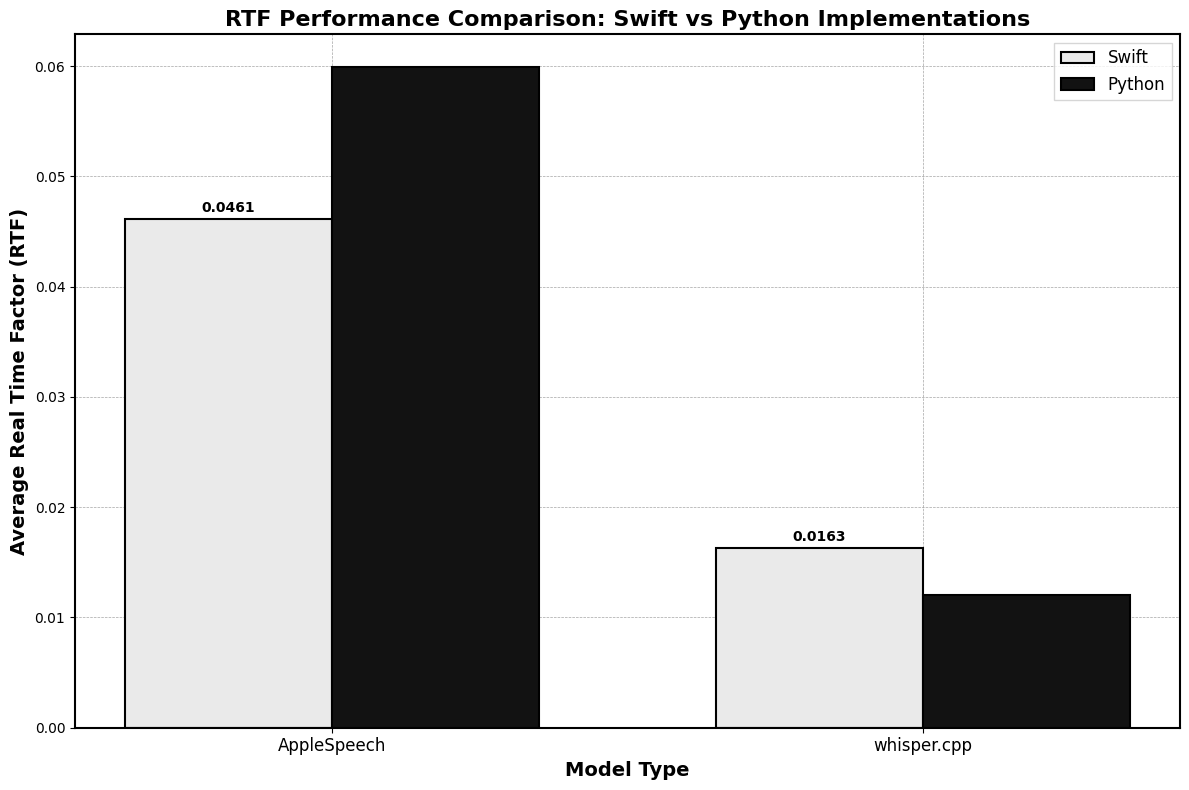


Implementation Performance Analysis:

Raw Performance Data:
AppleSpeech(onDevice,swift)    | RTF: 0.0461
whisper.cpp(tiny.en,swift)     | RTF: 0.0163
whisper_cpp(tiny.en, python)   | RTF: 0.0120
apple_speech(python)           | RTF: 0.0599

Language Comparison:
Swift implementations average:  0.0312
Python implementations average: 0.0360

Model Comparison:
AppleSpeech models: [0.0461, 0.0599]
whisper.cpp models: [0.0163, 0.012]

Performance Ranking (Best to Worst):
1. whisper_cpp(tiny.en, python) (Python): 0.0120 [BEST]
2. whisper.cpp(tiny.en,swift) (Swift): 0.0163 (+35.8%)
3. AppleSpeech(onDevice,swift) (Swift): 0.0461 (+284.2%)
4. apple_speech(python) (Python): 0.0599 (+399.2%)


In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# New RTF data comparing Swift and Python implementations
implementation_data = {
    'Implementation': [
        'AppleSpeech(onDevice,swift)',
        'whisper.cpp(tiny.en,swift)', 
        'whisper_cpp(tiny.en, python)',
        'apple_speech(python)'
    ],
    'Average_RTF': [0.0461, 0.0163, 0.0120, 0.0599],
    'Language': ['Swift', 'Swift', 'Python', 'Python'],
    'Model': ['AppleSpeech', 'whisper.cpp', 'whisper.cpp', 'AppleSpeech']
}

df_impl = pd.DataFrame(implementation_data)

# Create single figure
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Define colors for consistency
swift_color = '#eaeaea'  # Light gray for Swift
python_color = '#121212'  # Dark gray for Python

# Create grouped bar chart comparing implementations
x_pos = np.arange(2)  # 2 model types: AppleSpeech and whisper.cpp
width = 0.35

# Get data for each model type
apple_swift = df_impl[(df_impl['Model'] == 'AppleSpeech') & (df_impl['Language'] == 'Swift')]['Average_RTF'].iloc[0]
apple_python = df_impl[(df_impl['Model'] == 'AppleSpeech') & (df_impl['Language'] == 'Python')]['Average_RTF'].iloc[0]
whisper_swift = df_impl[(df_impl['Model'] == 'whisper.cpp') & (df_impl['Language'] == 'Swift')]['Average_RTF'].iloc[0]
whisper_python = df_impl[(df_impl['Model'] == 'whisper.cpp') & (df_impl['Language'] == 'Python')]['Average_RTF'].iloc[0]

# Create bars
bars_swift = ax.bar(x_pos - width/2, [apple_swift, whisper_swift], width, 
                    label='Swift', color=swift_color, edgecolor='black', linewidth=1.5)
bars_python = ax.bar(x_pos + width/2, [apple_python, whisper_python], width,
                     label='Python', color=python_color, edgecolor='black', linewidth=1.5)

# Add value labels for Swift bars
for bar, value in zip(bars_swift, [apple_swift, whisper_swift]):
    ax.annotate(f'{value:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, fontweight='bold', color='black')

# Add value labels for Python bars
for bar, value in zip(bars_python, [apple_python, whisper_python]):
    ax.annotate(f'{value:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, fontweight='bold', color='white')

# Customize the plot
ax.set_title('RTF Performance Comparison: Swift vs Python Implementations', fontsize=16, fontweight='bold')
ax.set_ylabel('Average Real Time Factor (RTF)', fontsize=14, fontweight='bold')
ax.set_xlabel('Model Type', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(['AppleSpeech', 'whisper.cpp'], fontsize=12)
ax.legend(frameon=True, fancybox=False, shadow=False, fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7, color='gray', linewidth=0.5)
ax.set_axisbelow(True)

# Set black border
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nImplementation Performance Analysis:")
print("=" * 60)
print("\nRaw Performance Data:")
for _, row in df_impl.iterrows():
    print(f"{row['Implementation']:<30} | RTF: {row['Average_RTF']:.4f}")

print("\nLanguage Comparison:")
swift_avg = df_impl[df_impl['Language'] == 'Swift']['Average_RTF'].mean()
python_avg = df_impl[df_impl['Language'] == 'Python']['Average_RTF'].mean()
print(f"Swift implementations average:  {swift_avg:.4f}")
print(f"Python implementations average: {python_avg:.4f}")

print("\nModel Comparison:")
apple_rtf = df_impl[df_impl['Model'] == 'AppleSpeech']['Average_RTF']
whisper_rtf = df_impl[df_impl['Model'] == 'whisper.cpp']['Average_RTF']
print(f"AppleSpeech models: {apple_rtf.tolist()}")
print(f"whisper.cpp models: {whisper_rtf.tolist()}")

# Sort by performance
sorted_df = df_impl.sort_values('Average_RTF')
best_rtf = sorted_df.iloc[0]['Average_RTF']

print("\nPerformance Ranking (Best to Worst):")
for i, (_, row) in enumerate(sorted_df.iterrows(), 1):
    if i == 1:
        print(f"{i}. {row['Implementation']} ({row['Language']}): {row['Average_RTF']:.4f} [BEST]")
    else:
        diff = ((row['Average_RTF'] - best_rtf) / best_rtf) * 100
        print(f"{i}. {row['Implementation']} ({row['Language']}): {row['Average_RTF']:.4f} (+{diff:.1f}%)")


AppleSpeech(onDevice,swift): Average RTF = 0.0461
whisper.cpp(tiny.en,swift): Average RTF = 0.0163
whisper.cpp(tiny.en, python)   Average: 0.0120
AppleSpeech(python)      Average: 0.0599